# Other Impact Factors

**Considering external impacts such as**

> 1. Holidays and Events. 
>
> 2. Daily oil price (Ecuador is an oil-dependent country).
>
> 3. Major crisis (A magnitude 7.8 earthquake struck Ecuador on April 16, 2016).
>
> 4. Dates to pay wages in the public sector.

# Importing Packages

In [1]:
from datetime import date

# Plotting import
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Kaggle Learning tools for plot styles
from plotting.time_series.utils import seasonal_plot

In [2]:
from pathlib import Path
comp_dir = Path('../input/store-sales-time-series-forecasting')

# Importing Data

In [3]:
train_data = pd.read_csv(
    comp_dir / "train.csv", index_col="id", header=0, parse_dates=["date"]
)
stores_data = pd.read_csv(
    comp_dir / "stores.csv", index_col="store_nbr", header=0
)
oil_data = pd.read_csv(
    comp_dir / "oil.csv", index_col="date", header=0, parse_dates=["date"]
)
transactions_data = pd.read_csv(
    comp_dir / "transactions.csv",
    index_col=None,
    header=0,
    parse_dates=["date"],
)

# Manipulating Data

In [4]:
range_begin = "2017"
range_end = "2017-08-15"

In [5]:
holidays_events_data = pd.read_csv(
    comp_dir / "holidays_events.csv",
    index_col=None,
    header=0,
    parse_dates=["date"],
)
holidays_events_data = holidays_events_data.astype(
    {
        "type": "category",
        "locale": "category",
        "locale_name": "category",
        "description": "category",
        "transferred": "bool",
    }
)
holidays_events_data = holidays_events_data.set_index("date").to_period("D")
holidays_events_data = holidays_events_data.loc[range_begin:range_end]

In [6]:
merged_data = pd.merge(
    train_data.groupby(["date", "store_nbr"]).sales.sum().reset_index(),
    transactions_data,
    how="left",
)

In [7]:
sales_grouped = train_data.groupby("date").agg({"sales": "sum"}).to_period("D")
sales_grouped["year"] = sales_grouped.index.year
sales_grouped["quarter"] = sales_grouped.index.quarter
sales_grouped["month"] = sales_grouped.index.month
sales_grouped["week"] = sales_grouped.index.week
sales_grouped["dayofweek"] = sales_grouped.index.dayofweek  # Monday=0 Sunday=6
sales_grouped["dayofmonth"] = sales_grouped.index.day  # Day from 01 to 31
sales_grouped["dayofyear"] = sales_grouped.index.dayofyear

# Impact Factors

## Holidays and Events

**They are important factors, because:**
1. People are off and have time on holidays, it's more likely that they will spend money on shoping.
2. Events usually promote sales with good deal, motivate people to spend more money.

**Type of Holidays:**
* A holiday that is `transferred` officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is `Transfer`. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. 
* Days that are type `Bridge` are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type `Work Day` which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
* `Additional` holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).
* `Event` is special days, for example, an earthquake event.

In [8]:
print(
    "Types of Holidays: {}".format(holidays_events_data.type.unique().tolist())
)
print(
    "Location types of Holidays: {}".format(
        holidays_events_data.locale.unique().tolist()
    )
)

Types of Holidays: ['Holiday', 'Transfer', 'Additional', 'Event']
Location types of Holidays: ['National', 'Local', 'Regional']


In [9]:
# Remove transferred Holidays

# Query only transferred-related days
transferred_days = holidays_events_data.loc[
    (holidays_events_data.transferred == True), ["type", "description"]
]
new_transferal_days = holidays_events_data.loc[
    (holidays_events_data.type == "Transfer")
]
# Replace "Tranfer" type with "Holiday",
#   replace descriptions back to original text
clean_transferal_days = (
    pd.concat(
        [new_transferal_days.reset_index(), transferred_days.reset_index()],
        axis=1,
    )
    .iloc[:, [0, 2, 3, 7, 8]]
    .set_index("date")
)
# Remove transferred Holidays
holidays = holidays_events_data.loc[
    (holidays_events_data.transferred == False)
    & (holidays_events_data.type != "Transfer")
].drop("transferred", axis=1)
holidays = holidays.append(clean_transferal_days).sort_index()

C:\Users\kim_l\AppData\Local\Temp\ipykernel_13532\1920514468.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  holidays = holidays.append(clean_transferal_days).sort_index()


In [10]:
# Clean special letters and numbers in `description`
holidays["description"] = (
    holidays["description"]
    .str.replace("-", "")
    .str.replace("+", "")
)
# `Additional` is also holiday
holidays["type"] = np.where(
    holidays["type"] == "Additional", "Holiday", holidays["type"]
)
# Bridge Holidays is also holiday
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays["type"] = np.where(
    holidays["type"] == "Bridge", "Holiday", holidays["type"]
)

C:\Users\kim_l\AppData\Local\Temp\ipykernel_13532\1250760778.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  holidays["description"]


In [11]:
# Separate types of Holiday
# Remove Work Day type
work_day = holidays.loc[holidays.type == "Work Day"]
holidays = holidays.loc[holidays.type != "Work Day"]

events = holidays.loc[holidays.type == "Event"]
holidays = holidays.loc[holidays.type != "Event"].drop("type", axis=1)

In [12]:
holidays = holidays.reset_index()
holidays_National = (
    holidays.loc[holidays.locale == "National"]
    .loc[:, ["date", "description"]]
    .set_index("date")
)
holidays_Regional = (
    holidays.loc[holidays.locale == "Regional"]
    .loc[:, ["date", "locale_name", "description"]]
    .set_index("date")
)
holidays_Local = (
    holidays.loc[holidays.locale == "Local"]
    .loc[:, ["date", "locale_name", "description"]]
    .set_index("date")
)

# Rename columns
holidays_National = holidays_National.rename(
    {"description": "holiday_national"}, axis=1
)
holidays_Regional = holidays_Regional.rename(
    {
        "description": "holiday_state",
        "locale_name": "state",
    },
    axis=1,
)
holidays_Local = holidays_Local.rename(
    {
        "description": "holiday_city",
        "locale_name": "city",
    },
    axis=1,
)

In [13]:
all_data = pd.merge(train_data, stores_data, on="store_nbr")
# reduce size of memory to boost performance
all_data["store_nbr"] = all_data["store_nbr"].astype("int8")
all_data["onpromotion"] = all_data["onpromotion"].astype("int16")

C:\Users\kim_l\AppData\Local\Temp\ipykernel_13532\3175385043.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(
C:\Users\kim_l\AppData\Local\Temp\ipykernel_13532\3175385043.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(


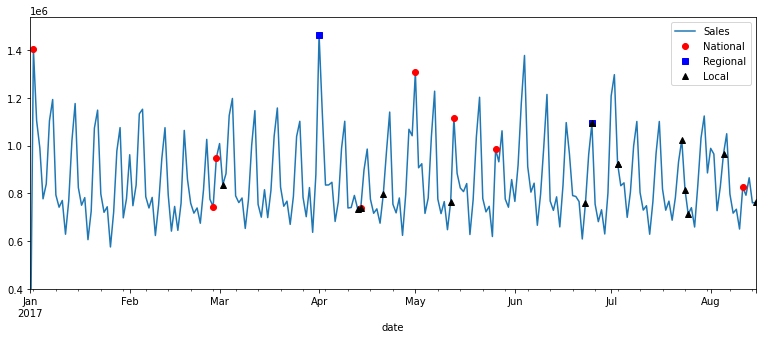

In [14]:
figsize = (13, 5)
fig, ax = plt.subplots(figsize=figsize)
sales_holidays = sales_grouped.loc[range_begin:range_end]
sales_holidays.plot(y="sales", ax=ax)
ax.plot_date(
    holidays_National.index,
    sales_holidays.loc[holidays_National.index].sales,
    color="r",
)
ax.plot_date(
    holidays_Regional.index,
    sales_holidays.loc[holidays_Regional.index].sales,
    color="b",
    marker="s",
)
ax.plot_date(
    holidays_Local.index,
    sales_holidays.loc[holidays_Local.index].sales,
    color="k",
    marker="^",
)
ax.legend(["Sales", "National", "Regional", "Local"])
ax.set(ylim=4e5)
plt.show()

## Oil Price

Ecuador is an oil-dependent country. In 2020, Ecuador was the fifth-largest oil producer in South America. For a number of years, Ecuador's economy saw constant growth thanks to high oil prices. When oil prices started to plummet in the end of 2014, economic growth began to stagnate and debt levels began to rise. **Does it influence the sales of grocery retailers?**

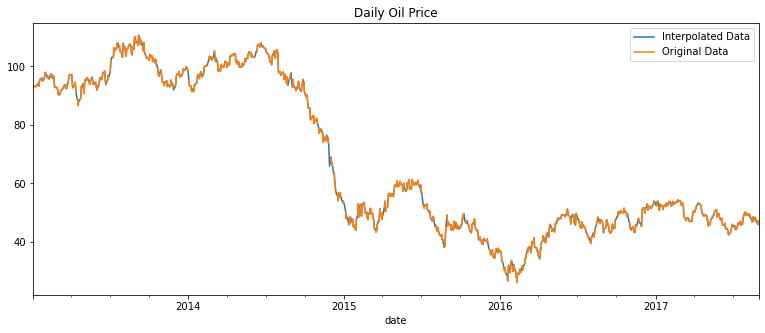

In [15]:
# Creating missing data with 0 values
oil = (
    oil_data.dcoilwtico.resample("D")
    .sum()
    .reset_index()
    .loc[1:]
    .set_index("date")
)

# Interpolate
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] = oil.dcoilwtico.interpolate()

# Plot
figsize = (13, 5)
fig, ax = plt.subplots(figsize=figsize)
oil.dcoilwtico_interpolated.plot(ax=ax)
oil.dcoilwtico.plot(ax=ax)
ax.set(title="Daily Oil Price")
ax.legend(["Interpolated Data", "Original Data"])
plt.show()

### What are its **Correlations** with Sales and Transactions

In [16]:
merged_data = pd.merge(
    merged_data,
    oil.drop("dcoilwtico", axis=1),
    how="left",
    left_on="date",
    right_index=True,
)

Correlations with Daily Oil Prices
sales          -0.303237
transactions    0.040105
Name: dcoilwtico_interpolated, dtype: float64 



Text(0.5, 1.0, 'Daily Oil Price & Sales')

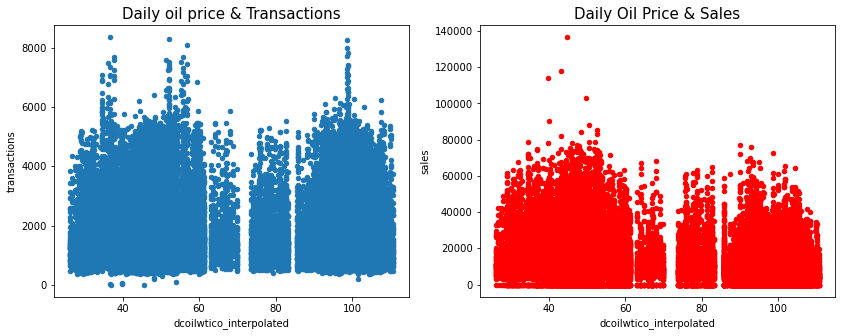

In [17]:
print("Correlations with Daily Oil Prices")
print(
    merged_data.drop("store_nbr", axis=1)
    .corr("spearman")
    .dcoilwtico_interpolated.loc[["sales", "transactions"]],
    "\n",
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
merged_data.plot.scatter(
    x="dcoilwtico_interpolated", y="transactions", ax=axes[0]
)
merged_data.plot.scatter(
    x="dcoilwtico_interpolated", y="sales", ax=axes[1], color="r"
)
axes[0].set_title("Daily oil price & Transactions", fontsize=15)
axes[1].set_title("Daily Oil Price & Sales", fontsize=15)

### Summary

* Spearman Correlations of Daily Oil Prices with Sales: -0.3, meaning there was a weak descreasing-monotonic trend between them. E.g., higher oil price leads slightly lower sales. [Read more about correlations](https://towardsdatascience.com/eveything-you-need-to-know-about-interpreting-correlations-2c485841c0b8)
* Spearman Correlations of Daily Oil Prices with Transactions: ~ 0, meaning there is no dependence between them.

In general, we can say people still did groceries but spent slightly more money when the oil price was low.

### Conclusion

On any graph, we can see there are 2 clusters divided by the oil price of 70. This was the time when the oil price fell greatly at the end of 2014. We expected Ecuador's economy to be worse and cause people to spend less. However, it's contrary to the fact that sales have a negative correlation with the oil price.
Overall, we can neglect the impact of daily oil prices on our model.

## Earthquakes

There were 2 major earthquakes between period of data we are working on:
1. 2014-08-12 at Pichincha with 5.1 Magnitude caused 4 deaths. Although it was not included in data, we could consider it later.
2. 2016-04-16 at Pedernales, Manabí with 7.8 Magnitude caused severe damage, 676 deaths. In Holidays and Events dataset, we can search for `description` with begining `Terremoto Manabi` until `Terremoto Manabi+30`

2016-04-16	Event	National	Ecuador	Terremoto Manabi	FALSE
2016-05-16	Event	National	Ecuador	Terremoto Manabi+30	FALSE

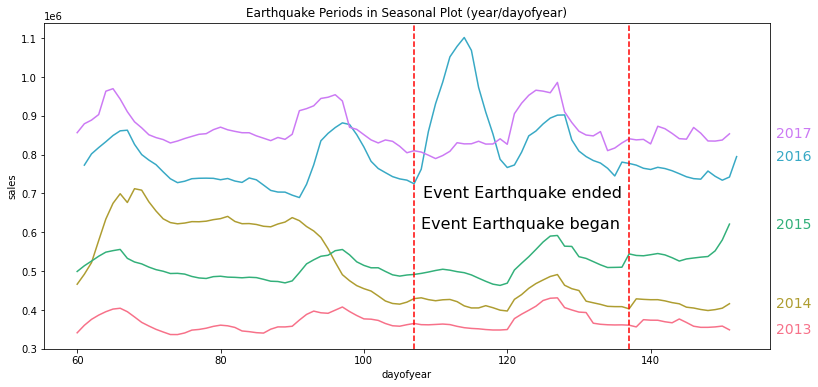

In [18]:
sales_smooth = sales_grouped.copy()
sales_smooth["sales"] = sales_smooth.sales.rolling(
    window=7, center=False, min_periods=2
).mean()

plotdata = sales_smooth.loc[:, ["sales", "year", "dayofyear"]]
plotdata = plotdata.loc[plotdata.index.month.isin([3, 4, 5])]
x_start = date(2016, 4, 16).timetuple().tm_yday
x_end = date(2016, 5, 16).timetuple().tm_yday

figsize = (13, 6)
fig, ax = plt.subplots(figsize=figsize)
seasonal_plot(
    plotdata,
    y="sales",
    period="year",
    freq="dayofyear",
    ax=ax,
    atext="Earthquake Periods in",
)

ax.set(ylim=3e5)
ax.axvline(x=x_start, color="r", linestyle="--")
ax.axvline(x=x_end, color="r", linestyle="--")
ax.annotate("Event Earthquake began", (x_start + 1, 6.1e5), fontsize=16)
ax.annotate(
    "Event Earthquake ended",
    (x_end - 1, 6.9e5),
    fontsize=16,
    horizontalalignment="right",
)
plt.show()

### Summary

We can see a sudden jump once the earthquake started. The peak was about $30\%$ increase than average.
People might want to stock food as inventory, or they bought and donated to people in damaged area. Let's see what families of products got boosted.

Therefore, we only look at the range from before earthquake 2 weeks, and after that 2 weeks.

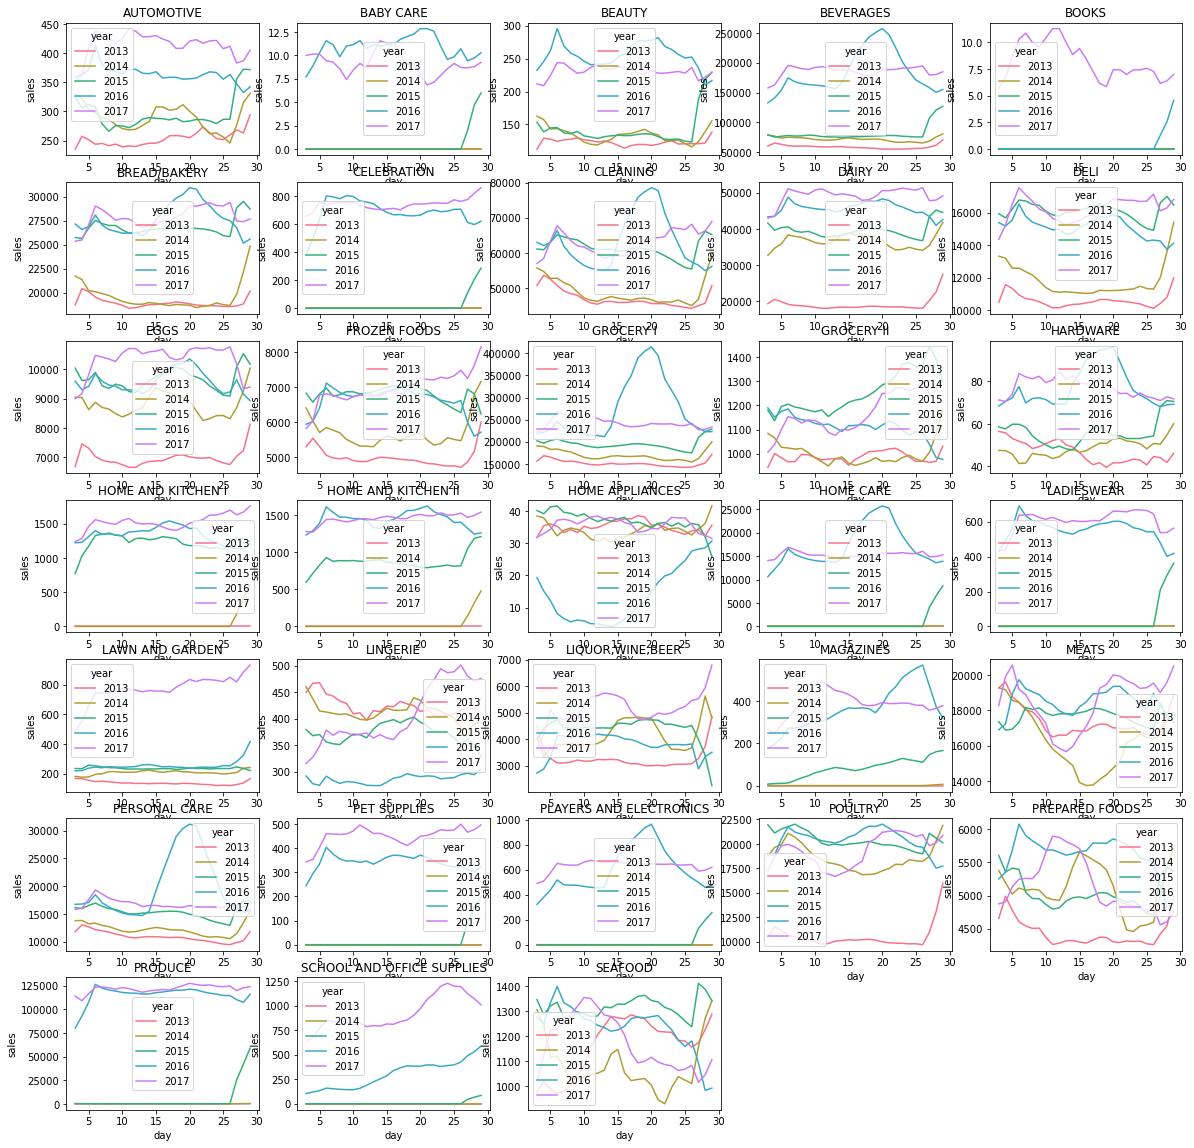

In [19]:
family_group = (
    train_data.drop(["store_nbr", "onpromotion"], axis=1)
    .loc[((train_data.date.dt.month == 4))]
    .loc[
        (
            (train_data.date.dt.day > 16 - 2 * 7)
            & (train_data.date.dt.day < 16 + 2 * 7)
        )
    ]
)
family_group = (
    family_group.groupby(["family", "date"])
    .agg({"sales": "sum"})
    .reset_index()
    .set_index("family")
)
family_group["year"] = family_group.date.dt.year
family_group["day"] = family_group.date.dt.day
families = family_group.index.unique().values
fig, axes = plt.subplots(7, 5, figsize=(20, 20))
palette = sns.color_palette("husl", n_colors=len(family_group.year.unique()))
for i, fam in enumerate(families):
    # print("{} {}".format(i, fam))
    plotdata = family_group.loc[fam].copy()
    plotdata["sales"] = plotdata.sales.rolling(
        window=7, center=True, min_periods=2
    ).mean()
    # plotdata.plot( 
    #   ax=axes[(i//6), i%6-1], x="date", y="sales",legend=None, style="year")
    sns.lineplot(
        data=plotdata.reset_index(),
        x="day",
        hue="year",
        y="sales",
        ax=axes[(i // 5), i % 5],
        palette=palette,
    )
    axes[(i // 5), i % 5].set_title(fam, fontsize=12)
fig.delaxes(axes[6][3])
fig.delaxes(axes[6][4])
plt.show()
# sns.lineplot(data=family_group, x="date", hue="family" ,y="sales")

### Conclusion

Based on separate family graph, we can identify which families of product were boosted:

1. Food: Beverages, Bread/Bakery, Grocery I
2. Home and tools: Cleaning, Hardware, Home Appliances and Home Care, Players and Electronics
3. Essential personal stuff: Personal Care

## Wage Paydays

Wages in the public sector are paid every two weeks on the 15 th and the last day of the month. Supermarket sales could be affected by this.

Although we see a strong pattern for weekly frequency, during a month, the sales could be impacted by whether people have money or not. When they get paid, meaning they have sparse money to spend.

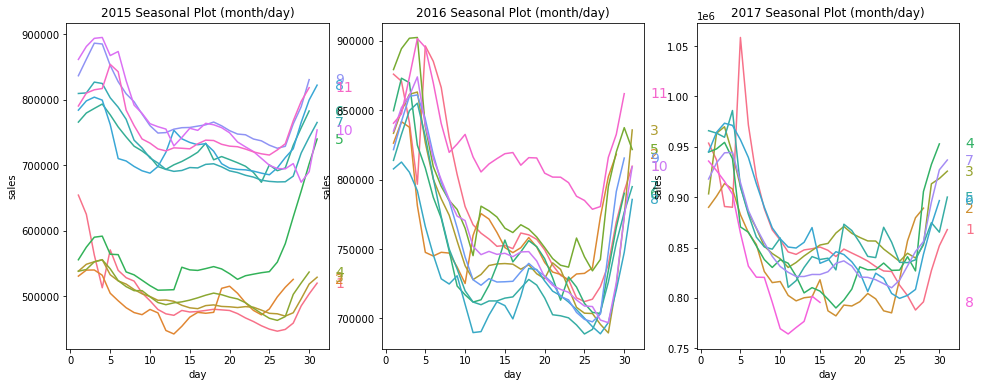

In [20]:
sales_smooth = sales_grouped.copy()
sales_smooth["sales"] = sales_smooth.sales.rolling(
    window=7, center=True, min_periods=2
).mean()
sales_smooth["year"] = sales_smooth.index.year
sales_smooth["month"] = sales_smooth.index.month
sales_smooth["day"] = sales_smooth.index.day

figsize = (16, 6)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
seasonal_plot(
    sales_smooth.loc[
        (sales_smooth["year"] == 2015) & (sales_smooth["month"] != 12)
    ],
    y="sales",
    period="month",
    freq="day",
    ax=ax1,
    atext="2015",
)
seasonal_plot(
    sales_smooth.loc[
        (sales_smooth["year"] == 2016)
        & (sales_smooth["month"] != 12)
        & (sales_smooth["month"] != 4)
    ],
    y="sales",
    period="month",
    freq="day",
    ax=ax2,
    atext="2016",
)
seasonal_plot(
    sales_smooth.loc[sales_smooth["year"] == 2017],
    y="sales",
    period="month",
    freq="day",
    ax=ax3,
    atext="2017",
)
plt.show()

### Conclusion

By rolling data with the window of 7, we eliminate the weekly pattern. There was a moderate peak in the middle of the month. It well indicated that people did spend money once they got paid. On top of that, there was a strong peak at the end and the beginning of each month. It indicated that people tend to buy groceries at the end/beginning of every month.